# Assignment

In [1]:
# Import 
import random
import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env_gym import *

import torch
from tianshou.data import Collector, ReplayBuffer
from tianshou.policy import DQNPolicy
from tianshou.utils.net.common import Net

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

c:\Users\Igor Kolasa\anaconda3\envs\dissertation\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. reset(). The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The method returns two dictionaries: `obs` and `info`. Each of them includes the following key-value pair:
     
     `obs['obs']` $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     `obs['mask']` $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     
     `info['board']` $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     

2. step(). The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). 

     `obs` $\;$ Similar to `obs` in reset() method, but computed for the position reached after the update of the system.

     `R` $\;$ The reward. To change this, look at the step() method of the class where the rewards are set.
     
     `terminated` $\;$ The termination flag indicating if the episode has ended (checkmate or draw).
     
     `truncated` $\;$ The truncation flag indicating if the episode has reached the maximum step limit (20 steps).
     
     `Done` $\;$ The Done signal. `Done = terminated or truncated`.
    
     `info` $\;$ Extra information given at each step.
     
     
3. Features(). Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [2]:
# Setting random seed to support reproducibility of results
seed = 42  

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# RESULTS TO PRODUCE

# ORIGINAL GAMMA AND BETA
# - Double DQN mean reward from 100 games    (taken every 500 steps)
# - Double DQN mean num moves from 100 games (taken every 500 steps)
DDQN_REWS = []
DDQN_MOVES = []

# CHANGED GAMMA AND ORIGINAL BETA
# - Double DQN mean reward from 100 games (taken every 500 steps)
# - Double DQN algorithm mean num moves from 100 games (taken every 500 steps)
DDQN_CHANGED_GAMMA_REWS = []
DDQN_CHANGED_GAMMA_MOVES = []

# ORIGINAL GAMMA AND CHANGED BETA
# - Double DQN mean reward from 100/ games (taken every 500 steps)
# - Double DQN algorithm mean num moves from 100 games (taken every 500 steps)
DDQN_CHANGED_BETA_REWS = []
DDQN_CHANGED_BETA_MOVES = []

# ORIGINAL GAMMA AND BETA
# - Different algorithm mean reward from 100 games (taken every 500 steps)
# - Different algorithm mean num moves from 100 games (taken every 500 steps)
DQN_REWS = []
DQN_MOVES = []


In [4]:
## INITIALISE THE TRAINING AND TESTING ENVIRONMENTS
# I had to initialise two separate environments as using the same
# environment for training and testing resulted in error, which led
# the agent to choose illegal actions
size_board = 4
train_env = Chess_Env_Gym(size_board)
test_env = Chess_Env_Gym(size_board)
state_shape = train_env.state_shape
action_shape = train_env.action_shape

# set up the Q-net, optimizer and policy
########### fill in your code ########### 
net = Net(
    state_shape,
    action_shape,
    hidden_sizes=[200],
    activation=torch.nn.ReLU
)
optim = torch.optim.Adam(net.parameters(), 1e-3)

# Double DQN
policy = DQNPolicy(
    net,
    optim,
    discount_factor=0.95,  # GAMMA
    target_update_freq=320,
    is_double=True
)

# set up the training and testing replay buffers and collectors
buffer_train = ReplayBuffer(size=20000)
train_collector = Collector(policy, train_env, buffer_train)
buffer_test = ReplayBuffer(size=20000)
test_collector = Collector(policy, test_env, buffer_test)

# customized training loop for Double DQN
epoch = 10
eps_train = 0.1   # epsilon value of the epsilon-greedy policy in the training phase
beta = 10          # BETA - controls speed of the epsilon decaying trend
step_per_epoch = 5000
step_per_collect = 20
update_per_step = 1 / 20  # update policy once after every 20 steps
batch_size = 30

steps = []
test_rews = []
test_n_moves = []
eps_train_0 = eps_train

for i in range(epoch):
    policy.set_eps(eps_train)
    eps_train = eps_train_0 / (1 + beta * i)  # decaying epsilon
    step_acc = 0
    while step_acc < step_per_epoch:
        # collect `step_per_collect` steps of traning transitions
        train_collect_result = train_collector.collect(n_step=step_per_collect)
        
        # accumulate number of steps `step_acc`
        step_acc += train_collect_result['n/st'] 
        
        for j in range(round(update_per_step * train_collect_result['n/st'])):
            # train policy with a sampled batch data from buffer
            loss = policy.update(batch_size, train_collector.buffer)
            loss = loss['loss'] 

        
        # After 200 steps, test the policy performance on 100 games
        if step_acc % 200 == 0:
            test_collect_result = test_collector.collect(n_episode=100)

            # mean reward per game
            test_rew = test_collect_result['rew']

            # mean number of moves per game (max is set to 20)
            test_len = test_collect_result['len']
            
            step = step_acc + step_per_epoch*i
            steps.append(step)
            test_rews.append(test_rew)
            test_n_moves.append(test_len)

            print(f'Step: {step}, train loss: {loss}, mean test reward per game: {test_rew}, mean test number of moves per game: {test_len}')

DDQN_CHANGED_BETA_REWS = test_rews
DDQN_CHANGED_BETA_MOVES = test_n_moves

Step: 200, train loss: 0.02043563686311245, mean test reward per game: 0.18, mean test number of moves per game: 12.14
Step: 400, train loss: 0.017134806141257286, mean test reward per game: 0.3, mean test number of moves per game: 8.18
Step: 600, train loss: 0.004435341339558363, mean test reward per game: 0.25, mean test number of moves per game: 9.86
Step: 800, train loss: 0.006034590303897858, mean test reward per game: 0.37, mean test number of moves per game: 9.43
Step: 1000, train loss: 0.016100618988275528, mean test reward per game: 0.36, mean test number of moves per game: 8.45
Step: 1200, train loss: 0.028521863743662834, mean test reward per game: 0.26, mean test number of moves per game: 9.96


KeyboardInterrupt: 

In [23]:
# Function calculating the moving average to reduce noise from the plots
def moving_average(values, window_size):
    moving_averages = []
    for i in range(len(values)):
        start_index = max(0, i - window_size + 1) # this is to avoid truncating the end of the original list
        window = values[start_index:i+1]
        average = sum(window) / len(window)
        moving_averages.append(average)
    
    return moving_averages
    
ma_window = 10 # moving average window

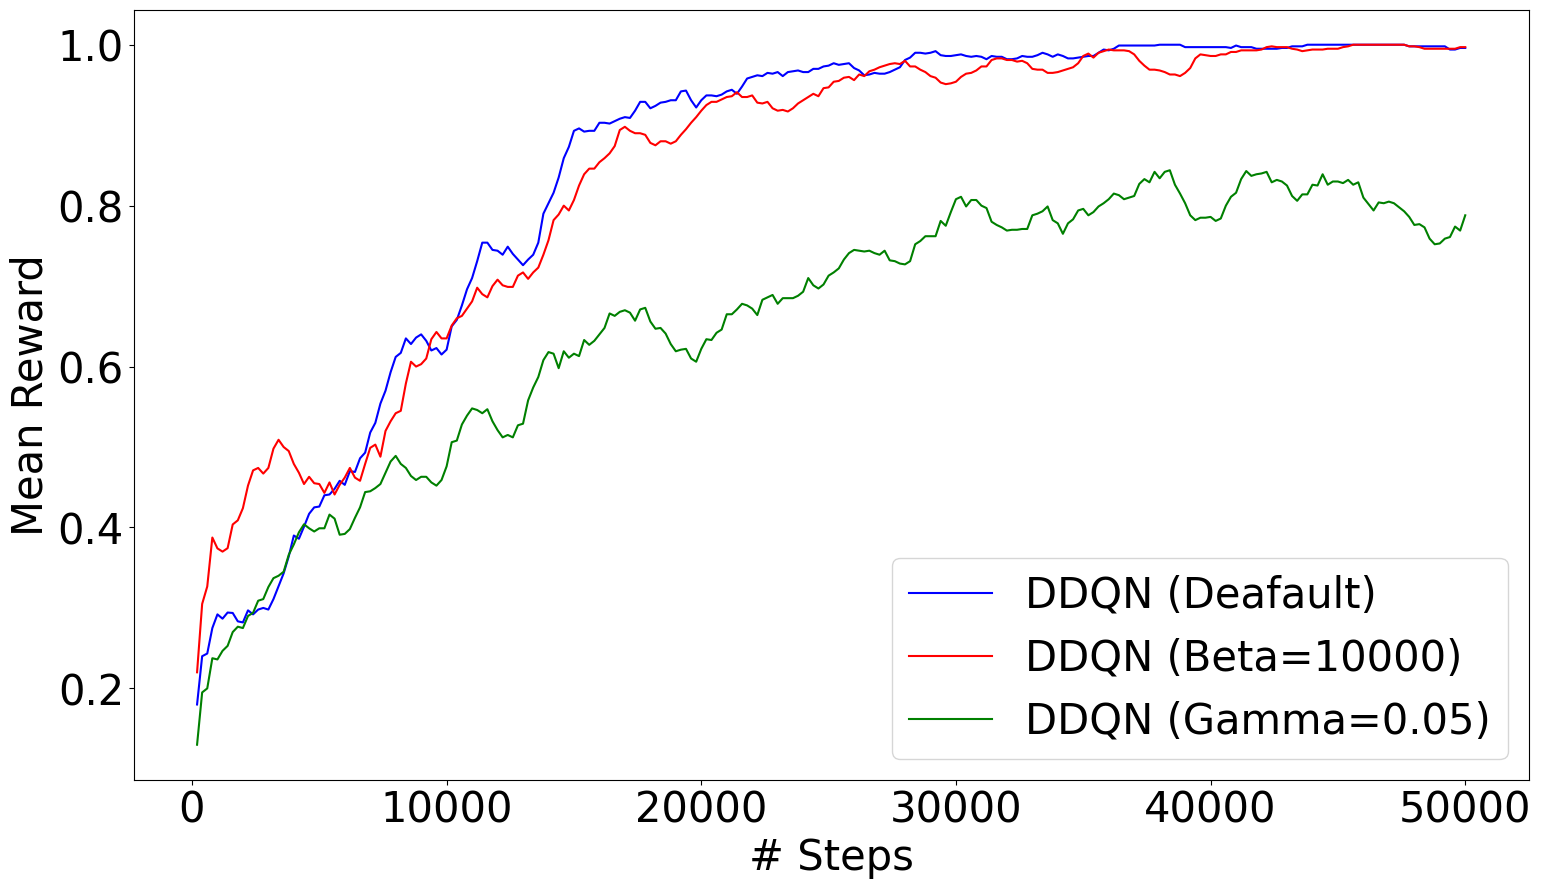

In [25]:
# Plot test rewards over number of steps
plt.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1,figsize=(18,10))

DDQN, = axs.plot(steps, moving_average(DDQN_REWS, ma_window), color='b')
DDQN_CHANGED_BETA, = axs.plot(steps, moving_average(DDQN_CHANGED_BETA_REWS, ma_window), color='r')
DDQN_CHANGED_GAMMA, = axs.plot(steps, moving_average(DDQN_CHANGED_GAMMA_REWS, ma_window), color='g')

axs.legend([DDQN, DDQN_CHANGED_BETA, DDQN_CHANGED_GAMMA], ['DDQN (Deafault)', 'DDQN (Beta=10000)', 'DDQN (Gamma=0.05)'])
plt.xlabel('# Steps')
plt.ylabel('Mean Reward')

fig.savefig('rewards_double.png', bbox_inches='tight')

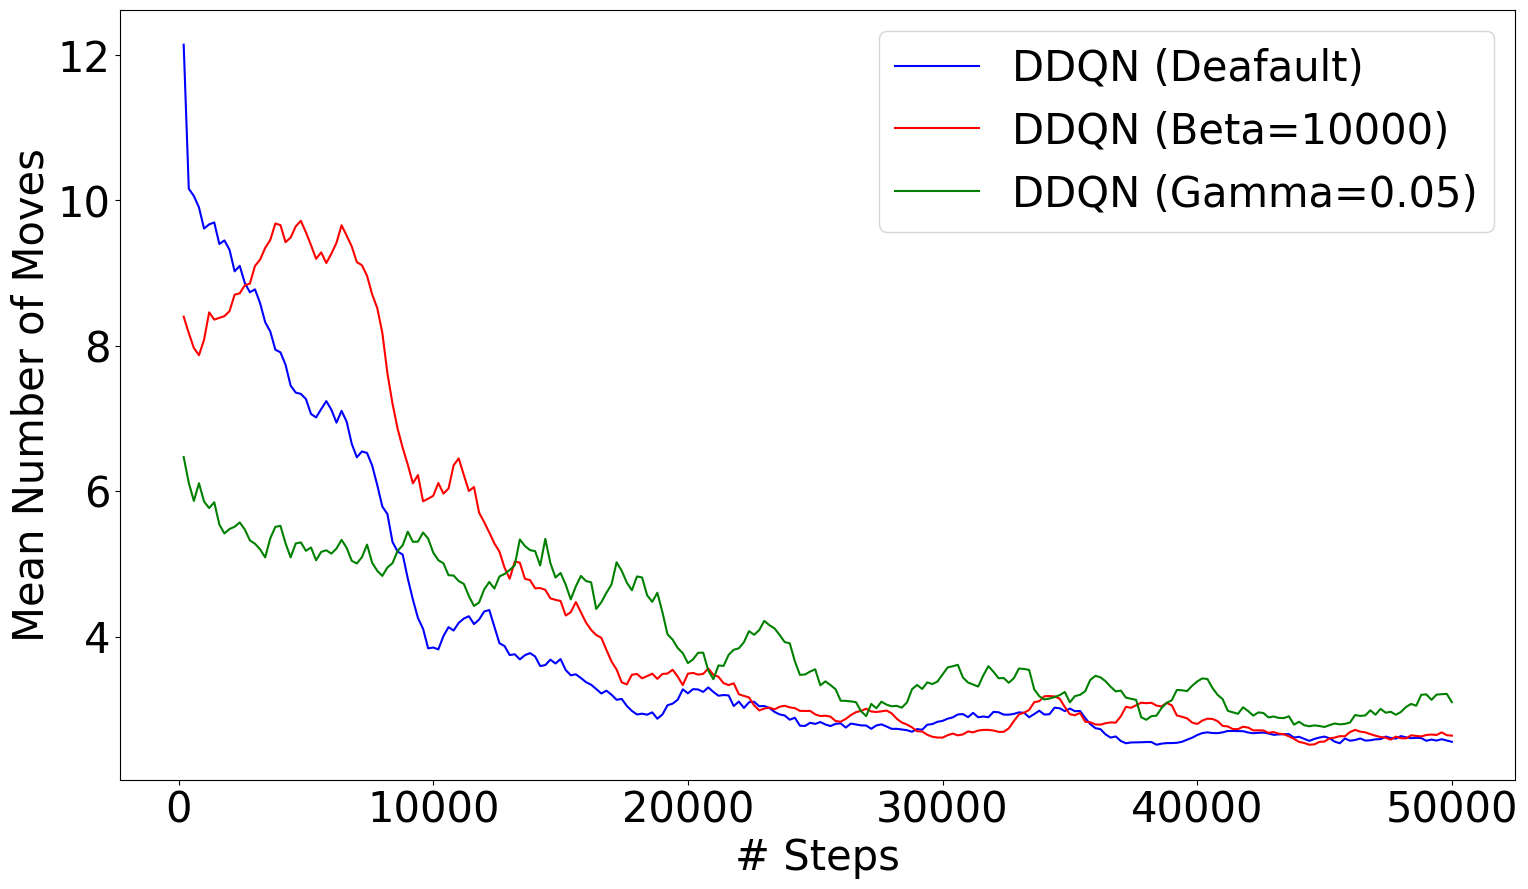

In [26]:
# Plot test number of moves over number of steps
plt.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1,figsize=(18,10))

DDQN, = axs.plot(steps, moving_average(DDQN_MOVES, ma_window), color='b')
DDQN_CHANGED_BETA, = axs.plot(steps, moving_average(DDQN_CHANGED_BETA_MOVES, ma_window), color='r')
DDQN_CHANGED_GAMMA, = axs.plot(steps, moving_average(DDQN_CHANGED_GAMMA_MOVES, ma_window), color='g')

axs.legend([DDQN, DDQN_CHANGED_BETA, DDQN_CHANGED_GAMMA], ['DDQN (Deafault)', 'DDQN (Beta=10000)', 'DDQN (Gamma=0.05)'])
plt.xlabel('# Steps')
plt.ylabel('Mean Number of Moves')

fig.savefig('moves_double.png', bbox_inches='tight')

In [27]:
## INITIALISE THE TRAINING AND TESTING ENVIRONMENTS
size_board = 4
train_env = Chess_Env_Gym(size_board)
test_env = Chess_Env_Gym(size_board)
state_shape = train_env.state_shape
action_shape = train_env.action_shape

# set up the Q-net, optimizer and policy
########### fill in your code ########### 
net = Net(
    state_shape,
    action_shape,
    hidden_sizes=[200],
    activation=torch.nn.ReLU
)
optim = torch.optim.Adam(net.parameters(), 1e-3)

# Vanilla DQN
policy = DQNPolicy(
    net,
    optim,
    discount_factor=0.95,  # GAMMA
    target_update_freq=320,
    is_double=False, # not using double-Q technique, the default value is True
)

# set up the training and testing replay buffers and collectors
buffer_train = ReplayBuffer(size=20000)
train_collector = Collector(policy, train_env, buffer_train)
buffer_test = ReplayBuffer(size=20000)
test_collector = Collector(policy, test_env, buffer_test)

# customized training loop for vanilla DQN
epoch = 10
eps_train = 0.1    # epsilon value of the epsilon-greedy policy in the training phase
beta = 10          # BETA - controls speed of the epsilon decaying trend
step_per_epoch = 5000
step_per_collect = 20
update_per_step = 1 / 20  # update policy once after every 20 steps
batch_size = 30

steps = []
test_rews = []
test_n_moves = []
eps_train_0 = eps_train

for i in range(epoch):
    policy.set_eps(eps_train)
    eps_train = eps_train_0 / (1 + beta * i)  # decaying epsilon
    step_acc = 0
    while step_acc < step_per_epoch:
        # collect `step_per_collect` steps of training transitions
        train_collect_result = train_collector.collect(n_step=step_per_collect)

        # accumulate number of steps `step_acc` 
        step_acc += train_collect_result['n/st']
        
        for j in range(round(update_per_step * train_collect_result['n/st'])):
            # train policy with a sampled batch data from buffer
            loss = policy.update(batch_size, train_collector.buffer)
            loss = loss['loss']
        
        # After 200 steps, test the policy performance on 100 games
        if step_acc % 200 == 0:
            test_collect_result = test_collector.collect(n_episode=100)

            # mean reward per game
            test_rew = test_collect_result['rew']

            # mean number of moves per game (max is set to 20)
            test_len = test_collect_result['len']
            
            step = step_acc + step_per_epoch*i
            steps.append(step)
            test_rews.append(test_rew)
            test_n_moves.append(test_len)

            print(f'Step: {step}, train loss: {loss}, mean test reward per game: {test_rew}, mean test number of moves per game: {test_len}')

DQN_REWS = test_rews
DQN_MOVES = test_n_moves

Step: 200, train loss: 0.003978719934821129, mean test reward per game: 0.19, mean test number of moves per game: 10.76
Step: 400, train loss: 0.002796405227854848, mean test reward per game: 0.2, mean test number of moves per game: 10.76
Step: 600, train loss: 0.0008084432338364422, mean test reward per game: 0.24, mean test number of moves per game: 10.08
Step: 800, train loss: 0.0020611046347767115, mean test reward per game: 0.2, mean test number of moves per game: 10.99
Step: 1000, train loss: 0.02372080832719803, mean test reward per game: 0.16, mean test number of moves per game: 12.29
Step: 1200, train loss: 0.02741306647658348, mean test reward per game: 0.2, mean test number of moves per game: 11.72
Step: 1400, train loss: 0.0023302019108086824, mean test reward per game: 0.16, mean test number of moves per game: 14.79
Step: 1600, train loss: 0.0014992934884503484, mean test reward per game: 0.26, mean test number of moves per game: 10.96
Step: 1800, train loss: 0.00114056712

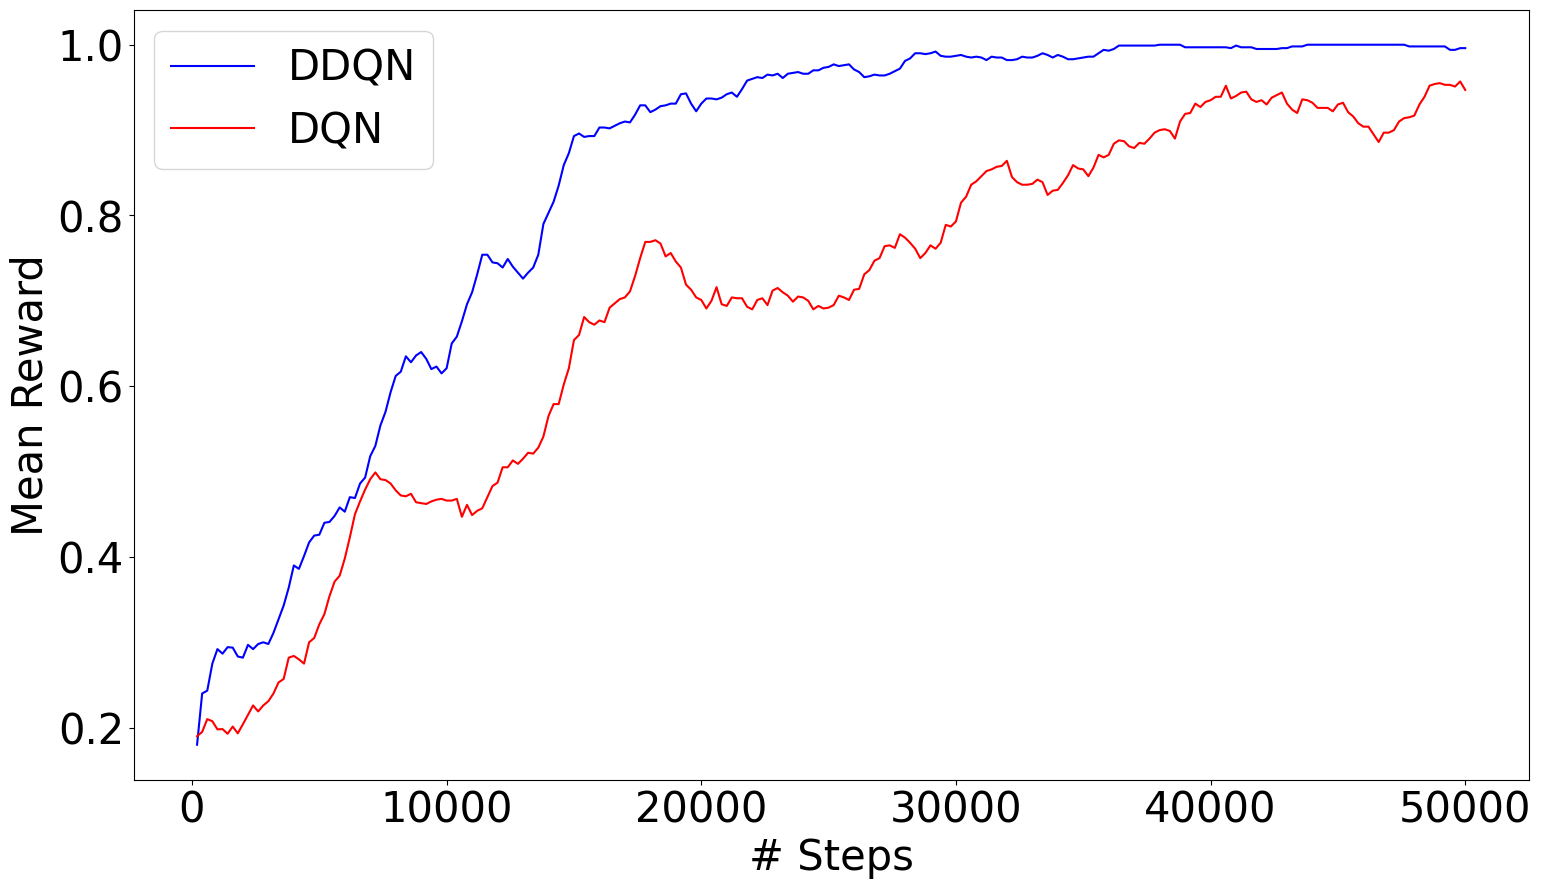

In [28]:
# Plot test rewards over number of steps
plt.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1,figsize=(18,10))

DDQN, = axs.plot(steps, moving_average(DDQN_REWS, ma_window), color='b')
DQN, = axs.plot(steps, moving_average(DQN_REWS, ma_window), color='r')

axs.legend([DDQN, DQN], ['DDQN', 'DQN'])
plt.xlabel('# Steps')
plt.ylabel('Mean Reward')

fig.savefig('rewards_dqnddqn.png', bbox_inches='tight')

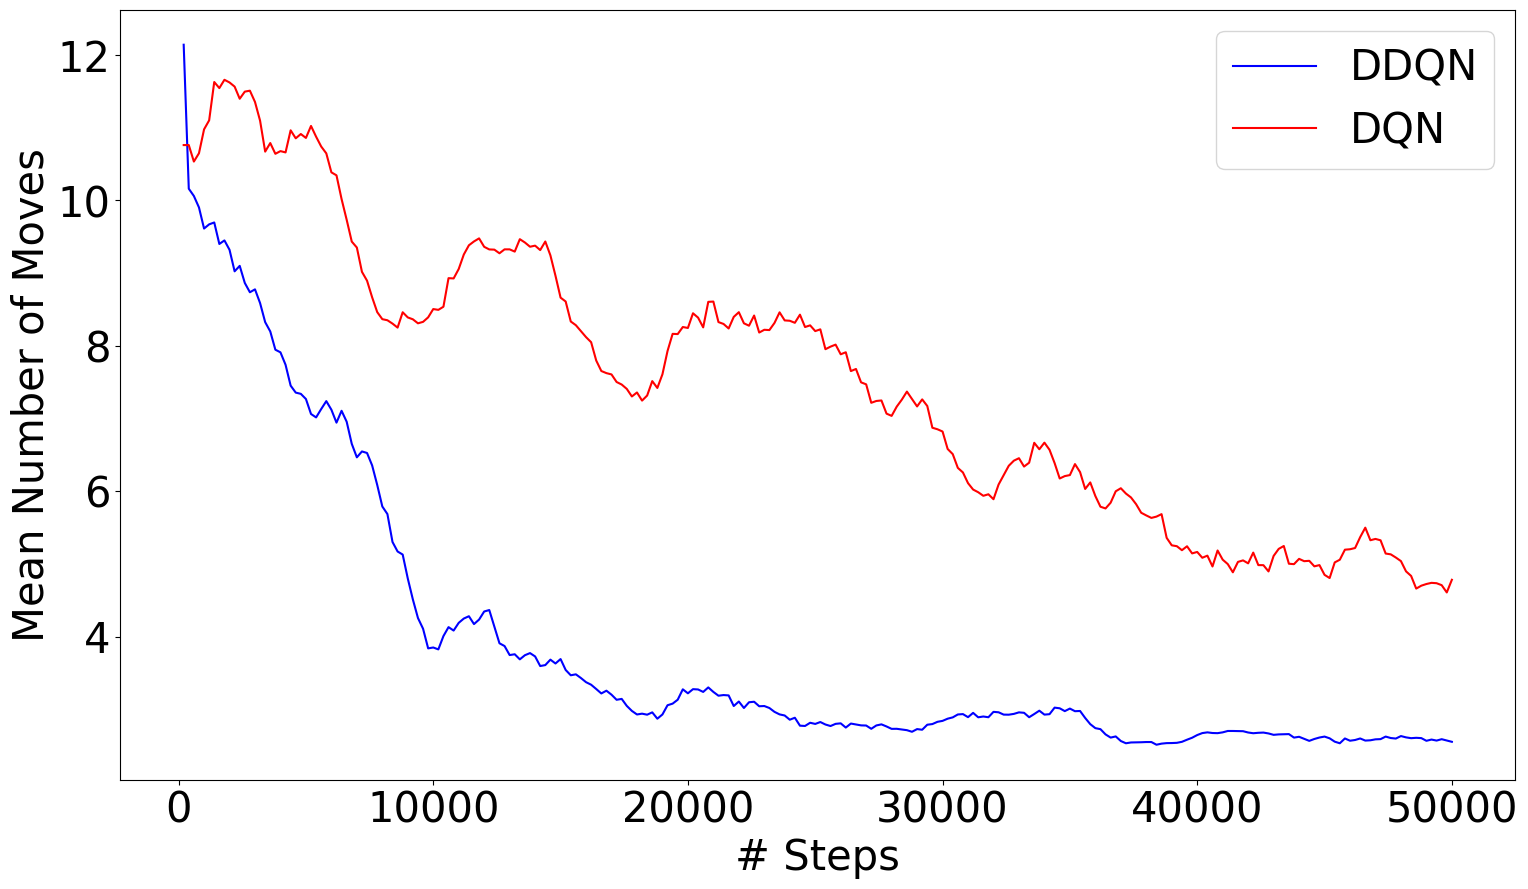

In [29]:
# Plot test moves over number of steps
plt.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1,figsize=(18,10))

DDQN, = axs.plot(steps, moving_average(DDQN_MOVES, ma_window), color='b')
DQN, = axs.plot(steps, moving_average(DQN_MOVES, ma_window), color='r')

axs.legend([DDQN, DQN], ['DDQN', 'DQN'])
plt.xlabel('# Steps')
plt.ylabel('Mean Number of Moves')

fig.savefig('moves_dqnddqn.png', bbox_inches='tight')